In [ ]:
# Mount into drive
from google.colab import drive

drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
'''
1. download chest_xray from https://drive.google.com/drive/folders/1LyOAgkKJOnjicDPaQSFrIDRMcG4YNl30
2. make an empty project folder at cs/Gatech/CS7643 Deep Learning/Summer 2023/project with %mkdir
3. drop downloaded folder in /content/drive/MyDrive/cs/Gatech/CS7643 Deep Learning/Summer 2023/project
'''

'\n1. download chest_xray from https://drive.google.com/drive/folders/1LyOAgkKJOnjicDPaQSFrIDRMcG4YNl30\n2. make an empty project folder at cs/Gatech/CS7643 Deep Learning/Summer 2023/project with %mkdir\n3. drop downloaded folder in /content/drive/MyDrive/cs/Gatech/CS7643 Deep Learning/Summer 2023/project\n'

In [ ]:
%cd '/content/drive/MyDrive/cs/Gatech/CS7643 Deep Learning/Summer 2023/project'

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-381de66a6a22>", line 1, in <cell line: 1>
    get_ipython().run_line_magic('cd', "'/content/drive/MyDrive/cs/Gatech/CS7643 Deep Learning/Summer 2023/project'")
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2418, in run_line_magic
    result = fn(*args, **kwargs)
  File "<decorator-gen-85>", line 2, in cd
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/magic.py", line 187, in <lambda>
    call = lambda f, *a, **k: f(*a, **k)
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/magics/osm.py", line 342, in cd
    oldcwd = os.getcwd()
OSError: [Errno 107] Transport endpoint is not connected

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/loc

In [ ]:
import math
import time
import io
import os
import pandas as pd
import numpy as np
import csv
import matplotlib as mat
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
import cv2
import glob
import pickle
pd.options.display.max_colwidth = 100

# Pytorch package
import torch
import torch.nn as nn
import torch.optim as optim

# Torchtest package
import torchtext
from torchtext.datasets import Multi30k
from torch.utils.data import DataLoader
from torchtext.data.utils import get_tokenizer
from collections import Counter
from torchtext.vocab import vocab
from torchtext.utils import download_from_url, extract_archive
from torch.nn.utils.rnn import pad_sequence

#sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn import metrics
from sklearn.metrics import accuracy_score

#tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#keras
import keras
from keras import callbacks
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.densenet import DenseNet121
from keras.layers import Dense
from keras.models import Model
from keras import backend as K

from tensorflow.random import set_seed
set_seed(42)

import warnings
warnings.filterwarnings('ignore')

from numpy.random import seed
seed(42)

os.environ['PYTHONHASHSEED'] = str(42)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

%matplotlib inline

# Tqdm progress bar
from tqdm import tqdm_notebook, tqdm
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# Check device availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("You are using device: %s" % device)

You are using device: cuda


In [ ]:
SEED = 42

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

#Setting callbakcs
early_stopping = callbacks.EarlyStopping(
    monitor = 'val_loss',          # The quantity to be monitored: validation loss
    patience = 4,                  # Number of epoch with no improvement after which training will be stopped.
    min_delta = 1e-5,              # An absolute change of less than min_delta, will count as no improvement.
    restore_best_weights = True,
)


# reduce the learning rate when a monitored quantity has stopped improving.
plateau = callbacks.ReduceLROnPlateau(
    monitor = 'val_loss',   # The quantity to be monitored: validation loss
    factor = 0.2,         # factor by which the learning rate will be reduced. New_lr = lr * 0.2
    patience = 2,         # Number of epoch with no improvement after which learning rate will reduced
    min_delt = 1e-5,      # An absolute change of less than min_delta, will count as no improvement.
    cooldown = 0,         # Number of epochs to wait before resuming normal operation after learning rate has been reduced.
    verbose = 1           # print a message to stdout for each update of the learning rate.
)
CALLBACKS = [early_stopping, plateau]

main_path = "chest_xray"

train_path = os.path.join(main_path,"train")
test_path=os.path.join(main_path,"test")

train_normal = glob.glob(train_path+"/NORMAL/*.jpeg")
train_pneumonia = glob.glob(train_path+"/PNEUMONIA/*.jpeg")

test_normal = glob.glob(test_path+"/NORMAL/*.jpeg")
test_pneumonia = glob.glob(test_path+"/PNEUMONIA/*.jpeg")

train_list = [x for x in train_normal]
train_list.extend([x for x in train_pneumonia])

df_train = pd.DataFrame(np.concatenate([['Normal']*len(train_normal) , ['Pneumonia']*len(train_pneumonia)]), columns = ['class'])
df_train['image'] = [x for x in train_list]

test_list = [x for x in test_normal]
test_list.extend([x for x in test_pneumonia])

df_test = pd.DataFrame(np.concatenate([['Normal']*len(test_normal) , ['Pneumonia']*len(test_pneumonia)]), columns = ['class'])
df_test['image'] = [x for x in test_list]

train_df, val_df = train_test_split(df_train, test_size = 0.20, random_state = SEED, stratify = df_train['class'])

In [ ]:
from keras.applications.densenet import DenseNet121
from keras.layers import Dense
from keras.models import Model
from keras import backend as K

def confusionMatrix(model, model_name, test):
  labels = ['Normal', 'Pneumonia']
  predictions = model.predict(test)
  binary_preds = (predictions >= 0.5).astype(int)

  cm = confusion_matrix(test.classes, binary_preds)
  cm = pd.DataFrame(cm , index = [0, 1] , columns = [0, 1])
  plt.figure(figsize = (5,5))
  sns.heatmap(cm, cmap = "Greens", annot = True, fmt='', xticklabels = labels, yticklabels = labels)
  plt.savefig(f"{model_name}_cm.png")

def getClassWeights(train):
  class_weight = {}
  total = len(train.classes)
  for idx, ele in enumerate(np.bincount(train.classes)):
    class_weight[idx] = (1. / ele) * (total / 2.)
  print(class_weight)
  return class_weight

def plotAccuracyEvolution(r, model_name):
  plt.figure(figsize=(12, 8))

  plt.subplot(2, 2, 1)
  plt.plot(r.history['loss'], label='Loss')
  plt.plot(r.history['val_loss'], label='Val_Loss')
  plt.legend()
  plt.title('Loss Evolution')

  plt.subplot(2, 2, 2)
  plt.plot(r.history['accuracy'], label='Accuracy')
  plt.plot(r.history['val_accuracy'], label='Val_Accuracy')
  plt.legend()
  plt.title('Accuracy Evolution')
  plt.savefig(f"{model_name}.png")

def densenetLoadConfig(yaml_loc, model_name):
  import yaml

  with open(yaml_loc, 'r') as file:
      config = yaml.safe_load(file)

  return config[model_name]

def densenetImageDataGenerator(config, train_df, val_df, df_test):
  from keras.preprocessing.image import ImageDataGenerator
  IMG_SIZE = config["img_size"]
  BATCH = config["batch"]

  train_datagen = ImageDataGenerator(rescale=1/255.,           # Normalizes the pixel values in the images into 0 to 1.
                                    zoom_range = 0.1,          # the range for random zoom. [1-zoom_range, 1+zoom_range]
                                    rotation_range = 0.1,     # rotate the image by a random amount within the range [-0.1, 0.1] radians.
                                    width_shift_range = 0.1,   # range within which to randomly translate pictures horizontally
                                    height_shift_range = 0.1)  # range within which to randomly translate pictures vertically

  val_datagen = ImageDataGenerator(rescale=1/255.)

  ds_train = train_datagen.flow_from_dataframe(train_df,
                                              #directory=train_path, #dataframe contains the full paths
                                              x_col = 'image',
                                              y_col = 'class',
                                              target_size = (IMG_SIZE, IMG_SIZE),
                                              class_mode = 'binary',
                                              batch_size = BATCH,
                                              seed = SEED)

  ds_val = val_datagen.flow_from_dataframe(val_df,
                                              #directory=train_path,
                                              x_col = 'image',
                                              y_col = 'class',
                                              target_size = (IMG_SIZE, IMG_SIZE),
                                              class_mode = 'binary',
                                              batch_size = BATCH,
                                              seed = SEED)

  ds_test = val_datagen.flow_from_dataframe(df_test,
                                              #directory=test_path,
                                              x_col = 'image',
                                              y_col = 'class',
                                              target_size = (IMG_SIZE, IMG_SIZE),
                                              class_mode = 'binary',
                                              batch_size = 1,
                                              shuffle = False)
  return ds_train, ds_val, ds_test

def densenetModelDefinition(config, METRICS):
  from keras.applications.densenet import DenseNet121
  from keras.layers import Dense
  from keras.models import Model
  from keras import backend as K

  img_size = config["img_size"]
  model = DenseNet121(input_shape=(img_size, img_size, 3),
                          include_top=False, #whether to include the fully-connected layer at the top of network
                          weights=config["ModelParams"]["weights"],
                          pooling=config["ModelParams"]["pooling"])
  predictions = Dense(1, activation="sigmoid")(model.output)
  model = Model(inputs=model.input, outputs=predictions)
  model.compile(loss='binary_crossentropy',
                optimizer=keras.optimizers.Adam(learning_rate=config["ModelParams"]["initial_learning_rate"]),
                metrics=METRICS)

  return model

def train_model(config, model, train, val, model_name, CALLBACKS):
  class_weight = getClassWeights(train)

  epochs = config["ModelParams"]["epochs"]
  batch = config["batch"]
  r = model.fit(
      train,
      epochs=epochs,
      validation_data=val,
      class_weight = class_weight,
      steps_per_epoch=(len(train.classes)/batch),
      validation_steps=(len(val.classes)/batch),
      callbacks=CALLBACKS
  )
  model.save(f'{model_name}.keras')
  return r

def evaluate_model(model, train, test):
  test_metrics = model.evaluate(test)
  train_metrics = model.evaluate(train)
  return (train_metrics, test_metrics)

In [ ]:
config_loc = "model_config.yaml"
model_names = ["baseline"]
train_output = {}
evaluate_output = {}

for ele in model_names:
  config = densenetLoadConfig(config_loc, ele)
  train, val, test = densenetImageDataGenerator(config, train_df, val_df, df_test)
  model = densenetModelDefinition(config, METRICS)

  train_output = train_model(config, model, train, val, ele, CALLBACKS)
  evaluate_output = evaluate_model(model, train, test)
  confusionMatrix(model, ele, test)

  pd.DataFrame(train_output.history).to_pickle(f"train_{ele}.pkl")
  # pickle.dump(evaluate_output,open(f"evaluate_{ele}.pkl", 'wb'))

Found 3506 validated image filenames belonging to 2 classes.
Found 877 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.
{0: 2.0080183276059564, 1: 0.6657804785415875}
Epoch 1/20
 97/109 [=========================>....] - ETA: 11s - loss: 0.4668 - tp: 2047.0000 - fp: 72.0000 - tn: 700.0000 - fn: 271.0000 - accuracy: 0.8890 - precision: 0.9660 - recall: 0.8831 - auc: 0.9461 - prc: 0.9786

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-926151e3275a>", line 11, in <cell line: 6>
    train_output = train_model(config, model, train, val, ele, CALLBACKS)
  File "<ipython-input-7-880a63947d22>", line 114, in train_model
    r = model.fit(
  File "/usr/local/lib/python3.10/dist-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/execute.py", line 52, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,
tensorflow.python.framework.errors_impl.UnknownError: Graph execution error:

2 root error(s) found.
  (0) UNKNOWN:  OSError: [Errno 107] Transport endpoint is not connected: 'chest_xray/train/PNEUMONIA/person1343_bacteria_3413.jpeg'
T

Found 3506 validated image filenames belonging to 2 classes.
Found 877 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.
{0: 2.0080183276059564, 1: 0.6657804785415875}
Epoch 1/20
109/109 [==============================] - 61s 446ms/step - loss: 0.3177 - tp: 4915.0000 - fp: 212.0000 - tn: 1534.0000 - fn: 351.0000 - accuracy: 0.9197 - precision: 0.9587 - recall: 0.9333 - auc: 0.9628 - prc: 0.9838 - val_loss: 5.3552 - val_tp: 115.0000 - val_fp: 0.0000e+00 - val_tn: 218.0000 - val_fn: 544.0000 - val_accuracy: 0.3797 - val_precision: 1.0000 - val_recall: 0.1745 - val_auc: 0.7458 - val_prc: 0.9165 - lr: 0.0010
Epoch 2/20
109/109 [==============================] - 47s 427ms/step - loss: 0.1349 - tp: 2503.0000 - fp: 45.0000 - tn: 828.0000 - fn: 130.0000 - accuracy: 0.9501 - precision: 0.9823 - recall: 0.9506 - auc: 0.9886 - prc: 0.9963 - val_loss: 0.1087 - val_tp: 652.0000 - val_fp: 27.0000 - val_tn: 191.0000 - val_fn: 7.0000 - val_ac

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-11-6be9ba2a8c87>", line 16, in <cell line: 15>
    train_hyper_params(ele, config_loc, train_df, val_df, df_test, METRICS, CALLBACKS)
  File "<ipython-input-11-6be9ba2a8c87>", line 6, in train_hyper_params
    train_output = train_model(config, model, train, val, ele, CALLBACKS)
  File "<ipython-input-7-b85f176274e3>", line 116, in train_model
    r = model.fit(
  File "/usr/local/lib/python3.10/dist-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/execute.py", line 52, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,
tensorflow.python.framework.errors_impl.UnknownError: Graph execution erro

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-11-6be9ba2a8c87>", line 16, in <cell line: 15>
    train_hyper_params(ele, config_loc, train_df, val_df, df_test, METRICS, CALLBACKS)
  File "<ipython-input-11-6be9ba2a8c87>", line 6, in train_hyper_params
    train_output = train_model(config, model, train, val, ele, CALLBACKS)
  File "<ipython-input-7-b85f176274e3>", line 116, in train_model
    r = model.fit(
  File "/usr/local/lib/python3.10/dist-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/execute.py", line 52, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,
tensorflow.python.framework.errors_impl.UnknownError: Graph execution erro

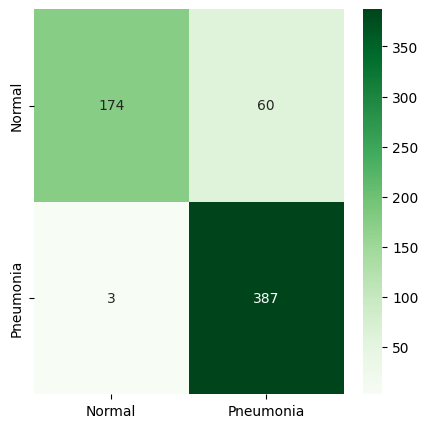

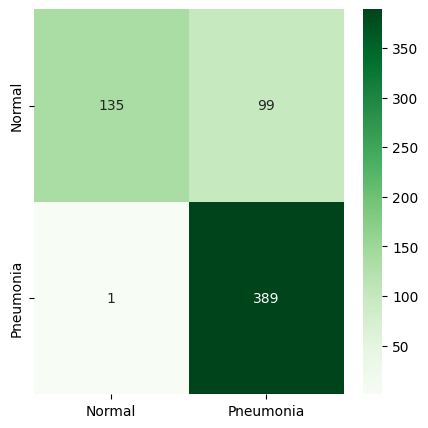

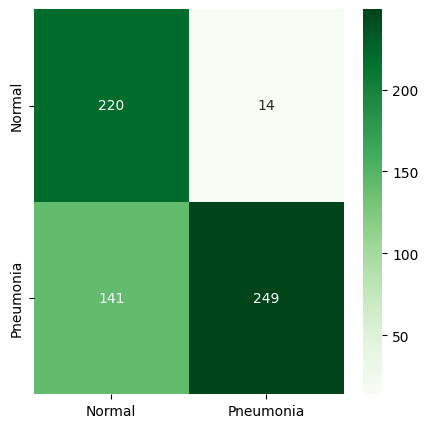

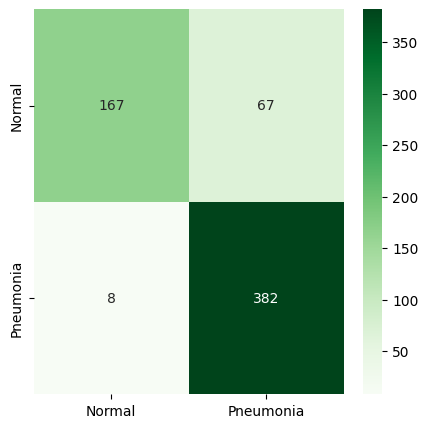

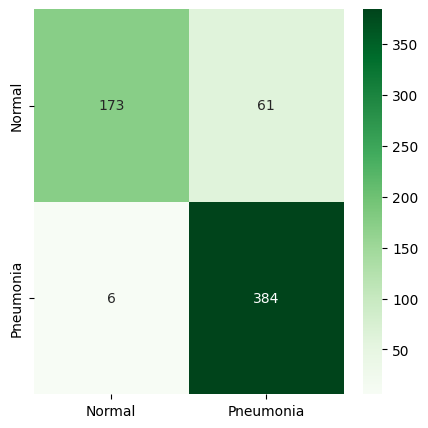

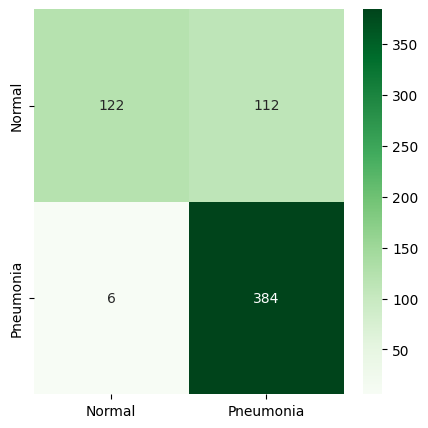

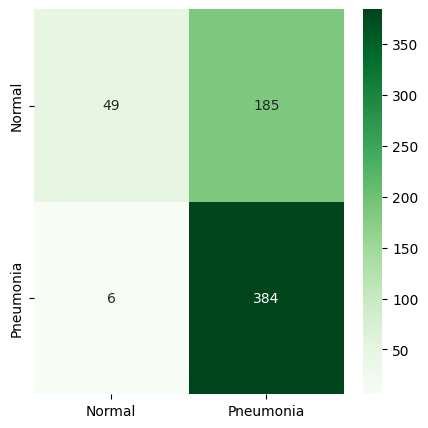

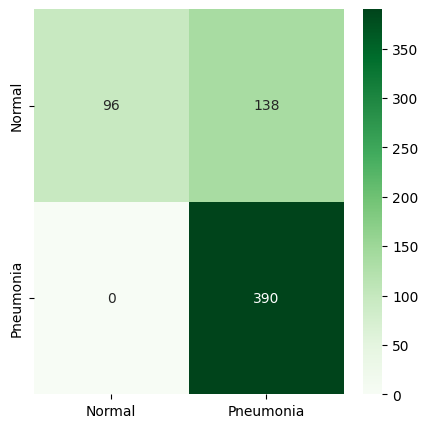

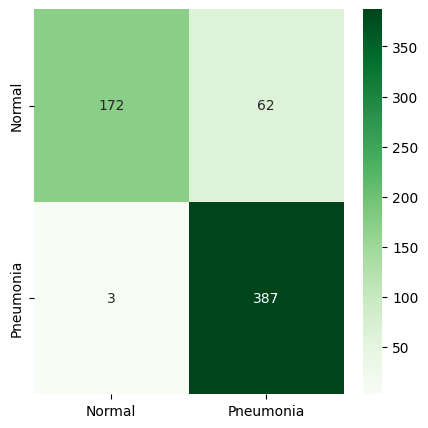

In [ ]:
def train_hyper_params(ele, config_loc, train_df, val_df, df_test, METRICS, CALLBACKS):
    config = densenetLoadConfig(config_loc, ele)
    train, val, test = densenetImageDataGenerator(config, train_df, val_df, df_test)
    model = densenetModelDefinition(config, METRICS)

    train_output = train_model(config, model, train, val, ele, CALLBACKS)
    evaluate_output = evaluate_model(model, train, test)
    confusionMatrix(model, ele, test)

    pd.DataFrame(train_output.history).to_pickle(f"train_{ele}.pkl")

config_loc = "model_config.yaml"
model_names = ["img_size_50", "img_size_100", "img_size_400", "learning_rate_16", "learning_rate_15", "learning_rate_14", "learning_rate_12", "learning_rate_11", "batch_16", "batch_8", "batch_64"]

for ele in model_names:
    train_hyper_params(ele, config_loc, train_df, val_df, df_test, METRICS, CALLBACKS)